# Importing standard libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Seeding values
### This is done so that code values stay uniform

In [2]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import random
random.seed(42)

# Reading the data into a dataframe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# reading in csv
file_path = '/content/drive/My Drive/DS340/cardio_train.csv'
df = pd.read_csv(file_path, sep=";")

df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


# Data preprocessing

In [53]:
# renaming some columns to reflect more understandable names
df = df.rename(columns={'ap_hi': 'sys_bp', 'ap_lo': 'dia_bp'})

# dropping the 'id' column as it doesn't provide any value
df = df.drop(columns=['id'])

# making age variable from days to years
df['age'] = df['age'].apply(lambda x: round(x/365,3))

In [54]:
df.head(10)

,age,gender,height,weight,sys_bp,dia_bp,cholesterol,gluc,smoke,alco,active,cardio
0,50.392,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282,2,169,82.0,150,100,1,1,0,0,1,1
4,47.874,1,156,56.0,100,60,1,1,0,0,0,0
5,60.038,1,151,67.0,120,80,2,2,0,0,0,0
6,60.584,1,157,93.0,130,80,3,1,0,0,1,0
7,61.874,2,178,95.0,130,90,3,3,0,0,1,1
8,48.405,1,158,71.0,110,70,1,1,0,0,1,0
9,54.340,1,164,68.0,110,60,1,1,0,0,0,0


# **Exploratory Data Analysis**

# Distribution of all features

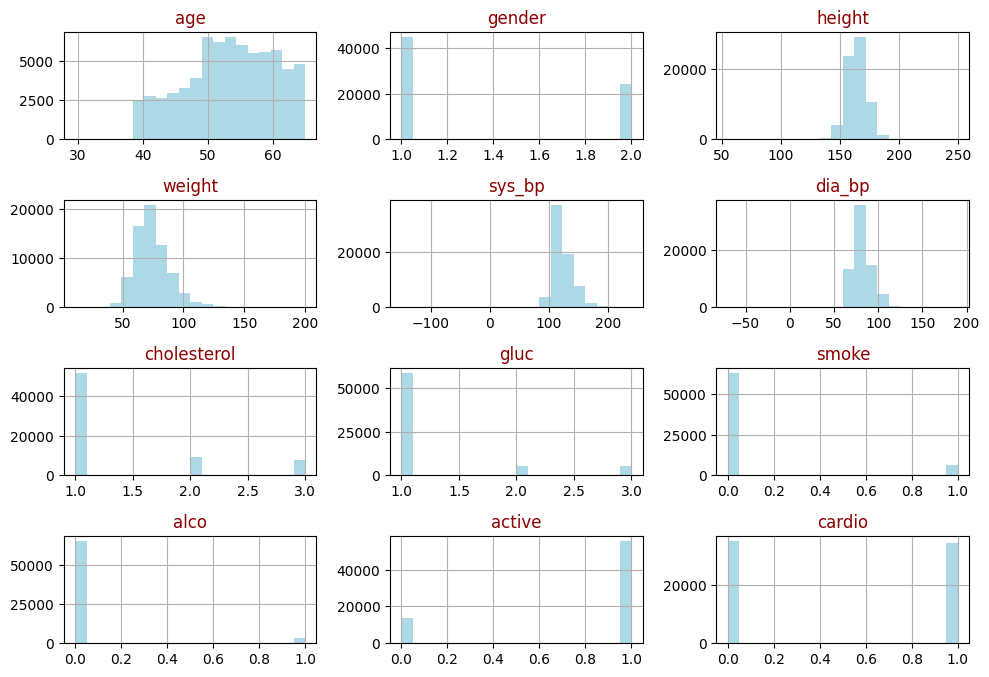

In [62]:
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (10, 10))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins = 20, ax = ax, facecolor = 'LightBlue')
        ax.set_title(feature, color = 'DarkRed')
    fig.tight_layout()
    plt.show()
draw_histograms(df, df.columns, 6, 3)

*There seems to be some clear outliers, specifically in the sys_bp and dys_bp variables, as you can't have a systolic or dystolic blood pressure over like 400 (highest recorded blood pressure was 370/360). Based on this, we will have to remove some outliers.*

# More data preprocessing
*Removing cases that have an 'impossible' systolic or diastolic blood pressure. We will define our outlier threshold as any cases where the systolic blood pressure or diastolic blood pressure above 250. A reading of 180/120 is defined as a "hypertensive crisis and a medical emergency". The highest blood pressure recording was during an experiment where a male individual recorded a 370/360 blood pressure reading. We believe our threshold eliminates most cases where blood pressure is likely entered incorrectly while still allowing for some extremely high blood pressure ratings in case these actually did occur.*

In [59]:
bp_outliers = df[(df['sys_bp'] > 250) | (df['dia_bp'] > 250)]
print(bp_outliers.shape)
bp_outliers[['sys_bp', 'dia_bp']].head(10)

(993, 12)


,sys_bp,dia_bp
228,160,1100
241,160,1000
260,140,800
329,160,1000
345,140,1000
473,150,1033
559,200,1000
613,140,1000
649,190,1100
653,180,1000


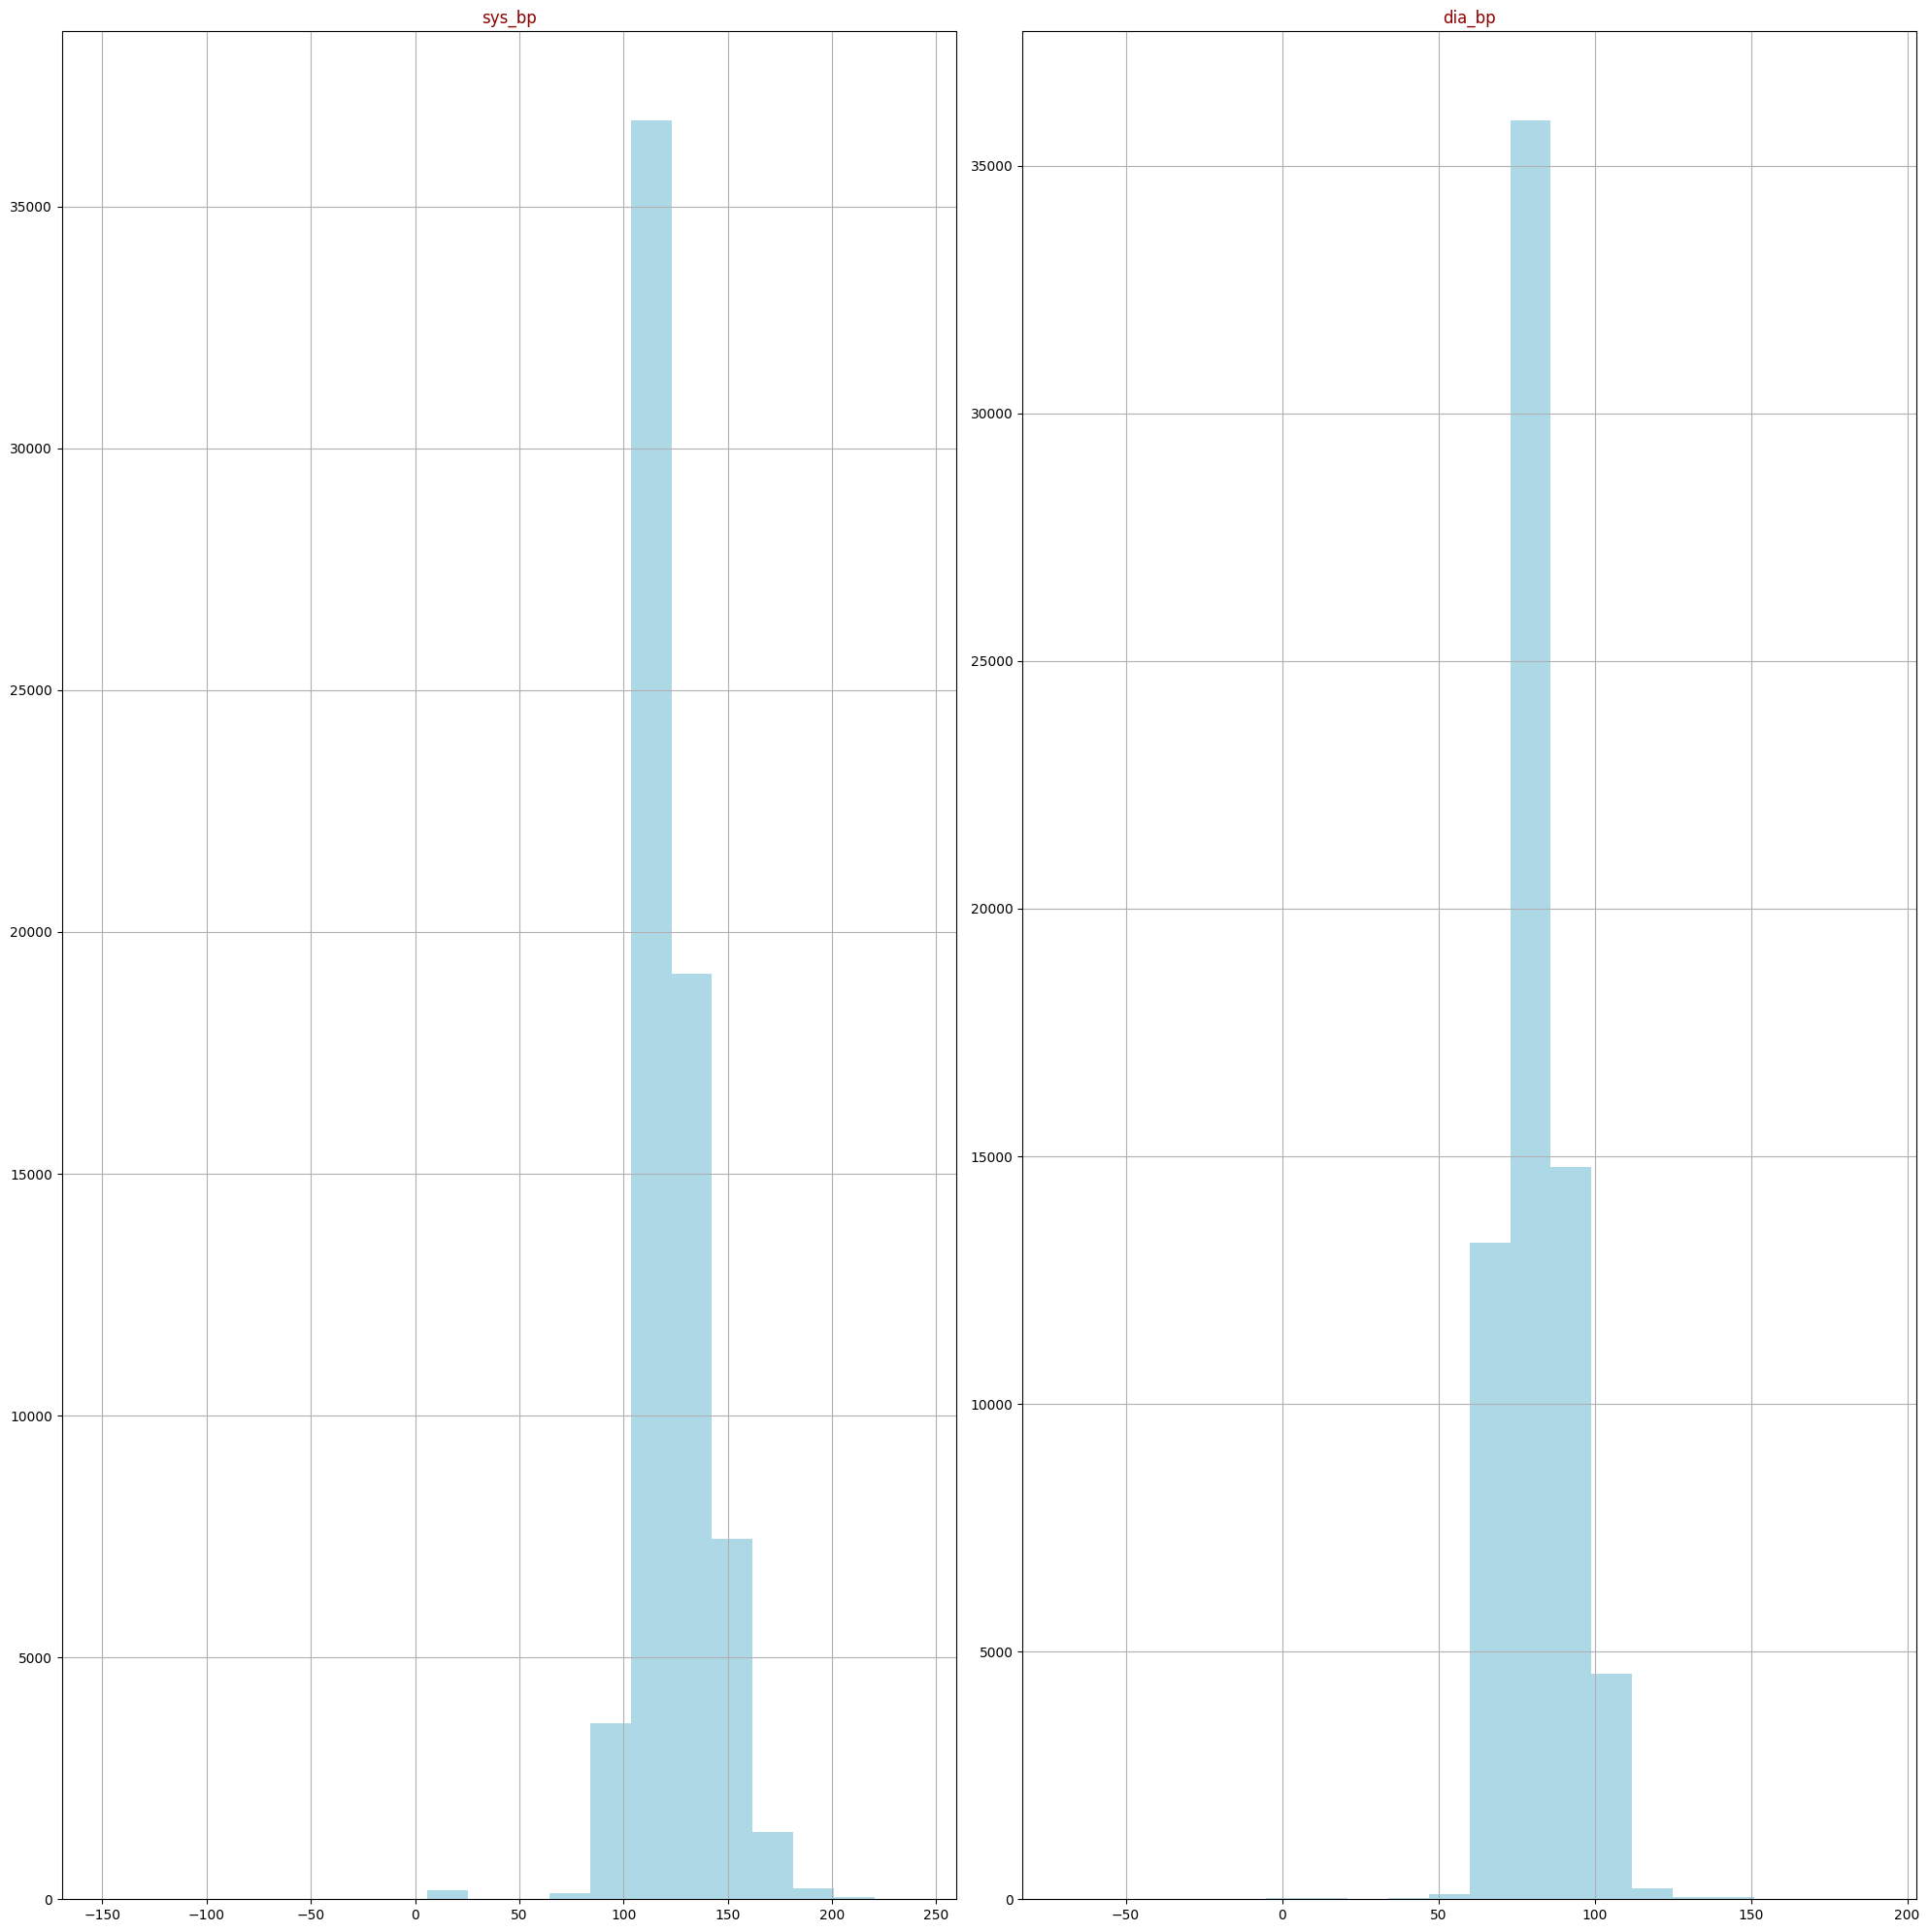

In [61]:
# getting rid of outliers from the original data frame
df = df[(df['sys_bp'] <= 250) & (df['dia_bp'] <= 250)]

*There also seem to be some blood pressure values that are 'impossible' on the lower end of the range. A blood pressure of 90/60 is considered to be low blood pressure. Values below 50/60 are considered very dangerous and likely fatal for systolic blood pressure, while anything below 30 for diastolic blood pressure is potentially fatal. Based on this, we will use thresholds of 30 for systolic blood pressure and 10 for diastolic blood pressure to determine 'impossible' values on the lower end of the ranges.*

In [65]:
bp_outliers = df[(df['sys_bp'] < 30) | (df['dia_bp'] < 10)]
print(bp_outliers.shape)
bp_outliers[['sys_bp', 'dia_bp']].head(10)

(205, 12)


,sys_bp,dia_bp
567,14,90
927,14,90
979,11,80
1600,12,80
1627,14,80
1772,11,60
2167,14,80
2203,12,80
2431,14,80
2528,12,80


In [66]:
# getting rid of outliers from the original data frame
df = df[(df['sys_bp'] >= 30) & (df['dia_bp'] >= 10)]

***Might need to consider removing any instances where the systolic blood pressure is lower than the diastolic blood pressure (as this may be very likely not possible)***

In [69]:
#outliers = df[(df['sys_bp'] < df['dia_bp'])]
#print(outliers.shape)
#outliers[['sys_bp', 'dia_bp']].head(10)

(101, 12)


,sys_bp,dia_bp
474,120,150
636,70,110
2384,90,150
2990,80,140
3447,80,125
3623,80,120
4825,90,140
4830,70,100
4941,80,170
5121,90,140


# Creating datasets of only men and only women

In [55]:
df_men = df[df['gender'] == 2].drop(columns=['gender'])

df_women = df[df['gender'] == 1].drop(columns=['gender'])

# Gender split analysis

gender
Female    45530
Male      24470
Name: count, dtype: int64


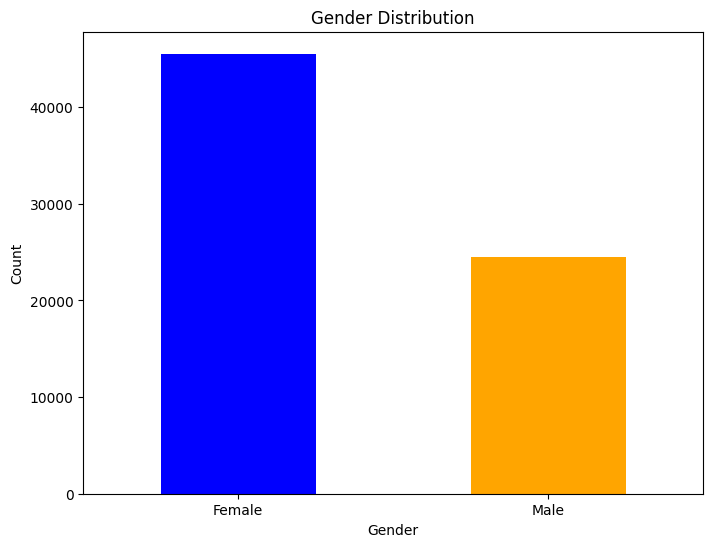

In [46]:
# getting gender distribution in the dataset
gender_counts = df['gender'].map({1: 'Female', 2: 'Male'}).value_counts()
print(gender_counts)

# Plotting
plt.figure(figsize=(8,6))
gender_counts.plot(kind='bar', color=['blue', 'orange'], )


plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*From this we can see that the gender split is pretty imbalanced. The difference in heart disease prediction by gender is something we want to investigate, specifically with which features impact a certain gender more than a the other.*

# Target variable distribution analysis

Patients with heart disease: 34979
Patients that don't have heart disease: 35021


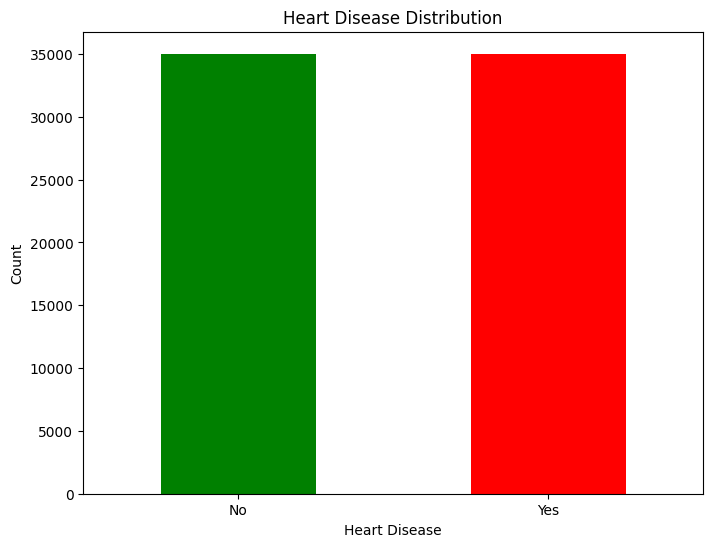

In [47]:
hd_counts = df['cardio'].map({0: 'No', 1:'Yes'}).value_counts()

print('Patients with heart disease:', hd_counts[1])
print("Patients that don't have heart disease:", hd_counts[0])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*The heart disease target variable in this data set is much more balanced than the data set the authors used previously. This is good as it will help limit potential bias in the model where it could just predict one of the variables for all predictions and still return a high accuracy.*

Patients with heart disease: 12107
Patients that do not have heart disease: 12363


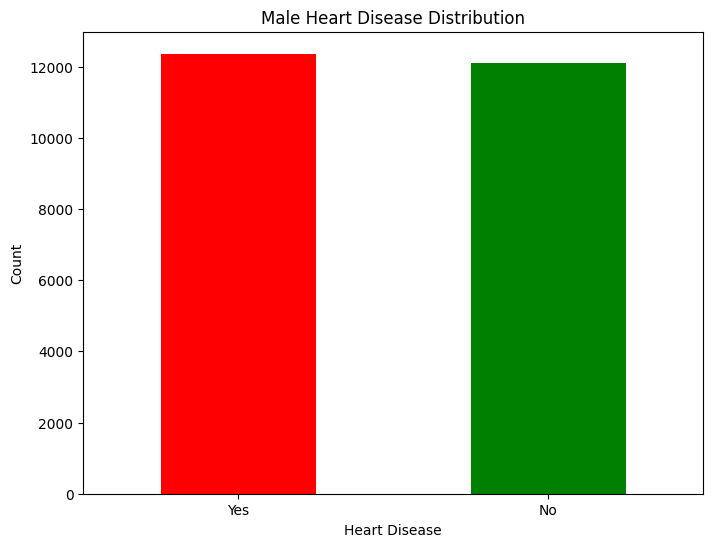

In [28]:
# heart distribution of males
hd_counts = df_men['cardio'].map({0: 'No', 1: 'Yes'}).value_counts()

print('Patients with heart disease:', hd_counts[1])
print('Patients that do not have heart disease:', hd_counts[0])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Male Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*This graph shows an even distribution of heart disease amongst males.*

Total patients at risk of CHD:  22616
Total patients not at risk of CHD:  22914


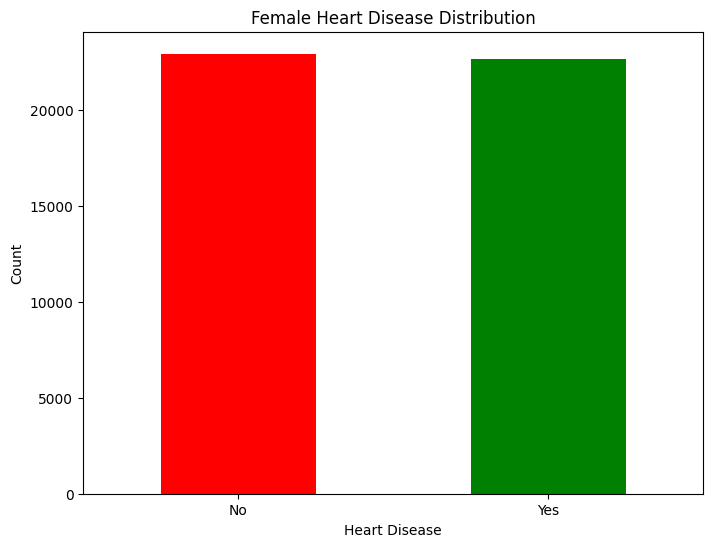

In [29]:
# heart disease distribution of females
hd_counts = df_women['cardio'].map({0: 'No', 1: 'Yes'}).value_counts()

print('Total patients at risk of CHD: ', hd_counts[1])
print('Total patients not at risk of CHD: ', hd_counts[0])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Female Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*This bar chart shows a very even distribution of heart disease amongst females*

**Correlation plot**

<Axes: >

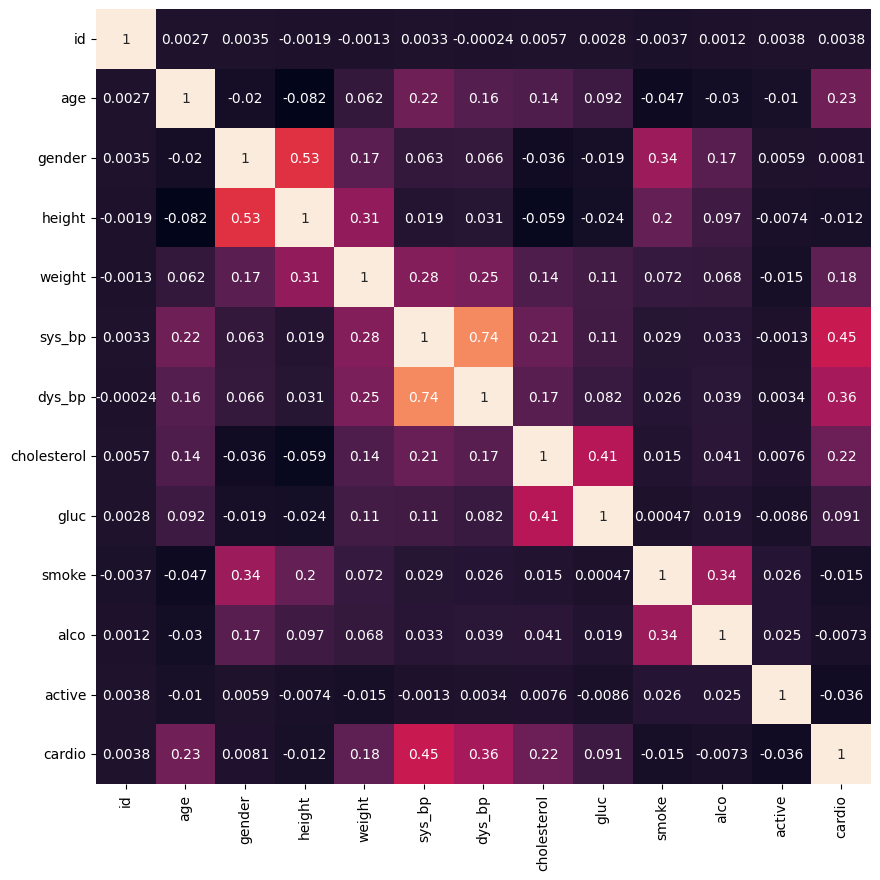

In [ ]:
corr = df.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)

*There is some significant correlation between systolic and dystolic blood pressure with having cardiovascular disease. This makes sense as blood pressure can be a easy indicator of heart diseases. Gender has very little correlation, which may point to the fact that a certain gender is not more susceptible to having a cardiovascular disease. Through our research we plan to see if this is true and how features impact gender differently.*

<Axes: >

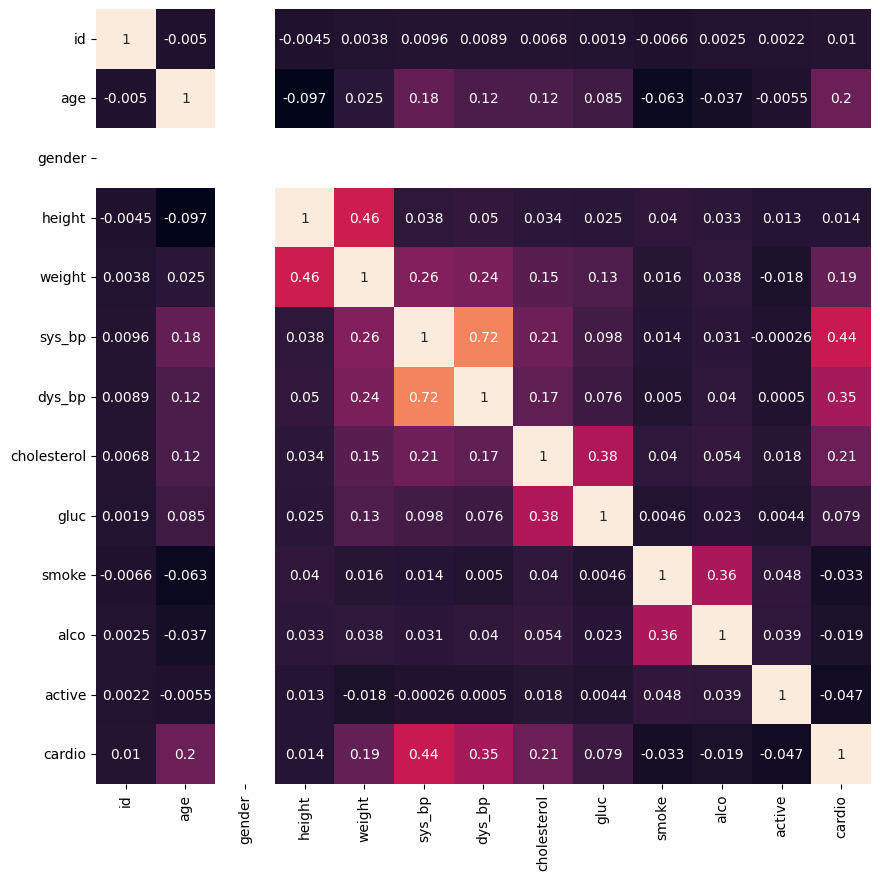

In [ ]:
corr = df_men.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)

<Axes: >

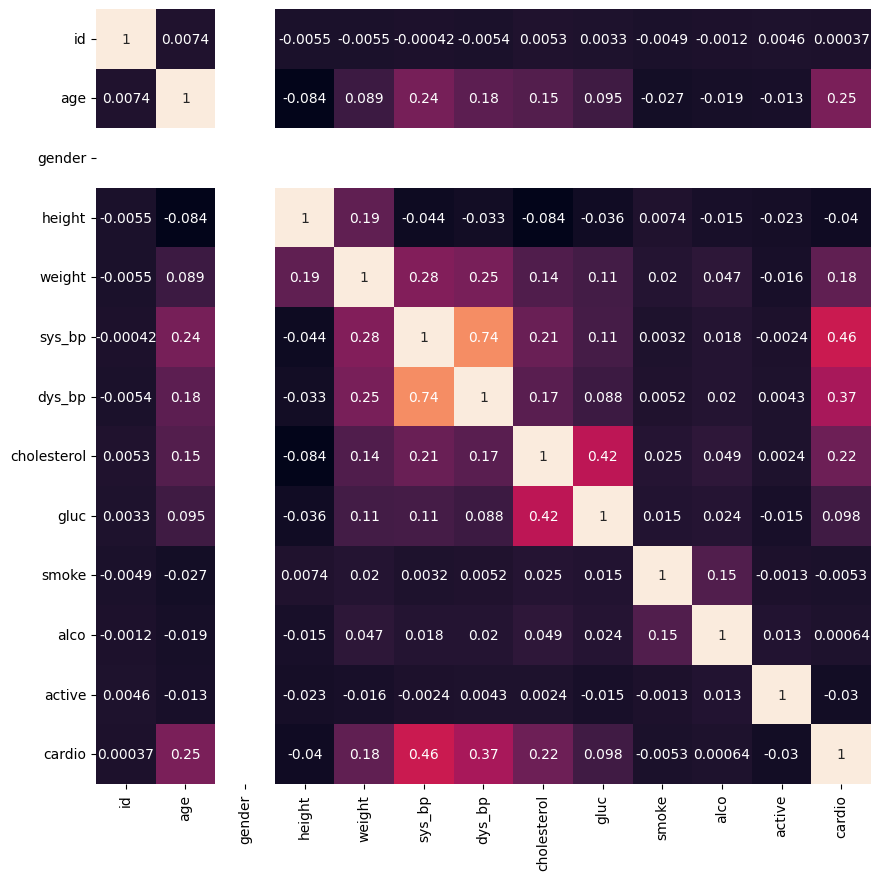

In [ ]:
corr = df_women.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)

*Comparing the mens vs womens correlation plots, the blood pressure numbers are slightly more correlated with heart disease in women. There were some other small differences in correlation values between variables and the target variable. Alcohol consumption has very little positive correlation (just about zero) with heart disease for women, while it is slightly negative (almost zero too) for men.*

**Missing values**

In [ ]:
print('Missing values: ')
print(df.isnull().sum())

mv = np.array(df.isnull().sum())
ta = 0
for t in mv:
    ta += t
print('\nTotal missing attributes: ', ta)

tr = 0
for i in df.isnull().sum(axis = 1):
    if i > 0:
        tr += 1
print('\nTotal rows with missing data: ', tr)

Missing values: 
id             0
age            0
gender         0
height         0
weight         0
sys_bp         0
dys_bp         0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Total missing attributes:  0

Total rows with missing data:  0


*No missing values in the dataset, so no imputation methods will be necessary*

**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/DS340/cardio_train.csv'
df = pd.read_csv(file_path, sep=";")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
# Step 3: Prepare the dataset
# Drop the 'id' column as it is not a feature
#df = df.drop(columns=['id'])

# Features (all columns except 'cardio') and Target (the 'cardio' column)
X = df.drop(columns=['cardio']).values  # Input features (11 features)
y = df['cardio'].values                 # Target variable (binary classification)

# Step 4: Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Step 5: Preprocess the data
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape the data for Conv1D (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(X_train[0])
print(X_train[1])
#print(X_val)
#print(X_test)

(44800, 12, 1)
(11200, 12, 1)
(14000, 12, 1)
[[ 1.07573875]
 [ 1.55932102]
 [ 1.36712698]
 [ 0.92818417]
 [ 0.68055465]
 [ 0.28070583]
 [ 0.01625734]
 [-0.53892692]
 [-0.39561945]
 [ 3.22978136]
 [-0.23781071]
 [ 0.49126479]]
[[ 0.7594374 ]
 [ 0.94925901]
 [-0.73146095]
 [ 0.20260164]
 [-0.77749084]
 [-0.05292314]
 [-0.08708765]
 [-0.53892692]
 [-0.39561945]
 [-0.30961848]
 [-0.23781071]
 [ 0.49126479]]


In [ ]:
# Example using RandomSearch from Keras Tuner for hyperparameter tuning
!pip install keras-tuner -q
import keras_tuner
from keras_tuner import RandomSearch

# Define a function that builds the model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu', input_shape=(12, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate Keras Tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='output', project_name='heart_disease_tuning')


# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Get the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss (after tuning): {test_loss}, Test Accuracy (after tuning): {test_acc}')



# Step 6: Build the CNN model
#model = Sequential()

# First Conv1D layer
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(11, 1)))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

# Second Conv1D layer
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

# Flatten and Dense layers
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

# Output layer (binary classification for heart disease prediction)
#model.add(Dense(1, activation='sigmoid'))

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#BAGGING CODE IS HERE
#model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

#from sklearn.ensemble import BaggingClassifier

# For overall dataset
#bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)
#bagging_model.fit(X_train, y_train)

# Male-only dataset
#male_data = df[df['gender'] == 2]
#X_male = male_data.drop(columns=['gender', 'cardio'])  # Adjust based on columns
#y_male = male_data['cardio']
#bagging_male = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)
#bagging_male.fit(X_male_train, y_male_train)

# Female-only dataset
#female_data = df[df['gender'] == 1]
#X_female = female_data.drop(columns=['gender', 'cardio'])  # Adjust based on columns
#y_female = female_data['cardio']
#bagging_female = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)
#bagging_female.fit(X_female_train, y_female_train)


# Step 8: Evaluate the model on the test set
#test_loss, test_acc = model.evaluate(X_test, y_test)
#print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Step 9: Make predictions on the test set
#y_pred_prob = model.predict(X_test)
#y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Step 10: Evaluate performance using various metrics
#print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Reloading Tuner from output/heart_disease_tuning/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
112               |80                |filters
3                 |3                 |kernel_size
0.1               |0.5               |dropout_rate
64                |32                |dense_units

Conv1D output shape: (None, 10, 112)
MaxPooling1D output shape: (None, 5, 112)
Flatten output shape: (None, 560)
Epoch 1/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6642 - loss: 0.6167 - val_accuracy: 0.7126 - val_loss: 0.5753
Epoch 2/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7198 - loss: 0.5663 - val_accuracy: 0.7222 - val_loss: 0.5648
Epoch 3/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7252 - loss: 0.5576 - val_accuracy: 0.7267 - val_loss: 0.5599
Epoch 4/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7270 - loss: 0.5549 - val_accuracy: 0.7278 - val_loss: 0.5598
Epoch 5/20
1400/1400 ━━━━━━━

KeyboardInterrupt: 